# Business Objective:
## To forecast CO2 levels for an organization so that the organization can follow government norms with respect to CO2 emission levels


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib import pylab
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [46]:
df = pd.read_excel("CO2 dataset.xlsx")
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


In [48]:
df.describe()

,Year,CO2
count,215.000000,215.000000
mean,1907.000000,6.741970
std,62.209324,6.522437
min,1800.000000,0.001750
25%,1853.500000,0.041050
50%,1907.000000,6.390000
75%,1960.500000,11.500000
max,2014.000000,18.200000


<AxesSubplot:ylabel='CO2'>

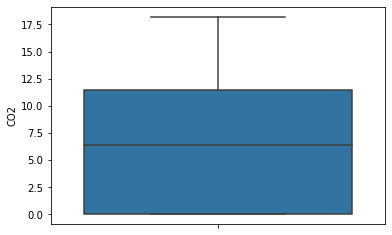

In [49]:
sns.boxplot(y= df['CO2'])

<AxesSubplot:ylabel='CO2'>

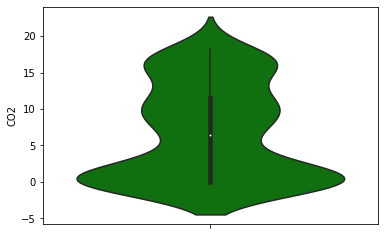

In [50]:
sns.violinplot(y= df['CO2'], color= "green")

In [51]:
# Lets create the copy of the data-frame
df1= df.copy()
df1.set_index("Year", inplace=True)
df1.head()

,CO2
Year,
1800,0.00568
1801,0.00561
1802,0.00555
1803,0.00548
1804,0.00542


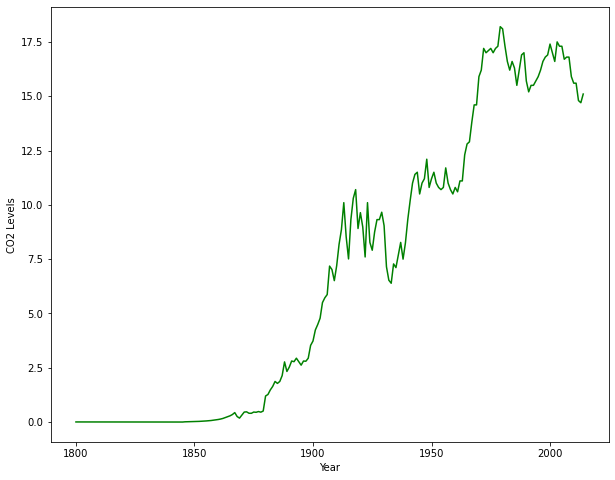

In [52]:
# Lets try to see the variation in CO2 levels with respect to year
plt.figure(figsize=(10,8))
plt.plot(df1, color= "green")
plt.xlabel("Year")
plt.ylabel("CO2 Levels")
plt.show()

<AxesSubplot:ylabel='Count'>

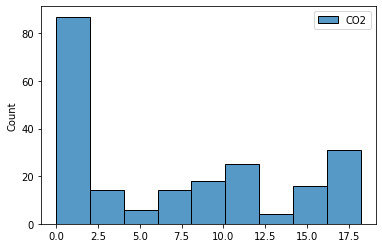

In [53]:
# Lets check for the type of the distribution of the data
sns.histplot(df1)

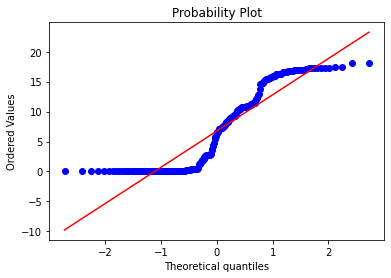

In [54]:
# Lets plot the Q-Q plot to see the type of distribution
stats.probplot(df1["CO2"],plot =pylab)
plt.show()

<AxesSubplot:xlabel='CO2', ylabel='Density'>

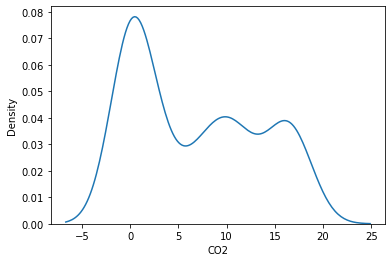

In [55]:
sns.kdeplot(df1["CO2"])

In [56]:
# from above graphs, we can analyze that data points are not following the normal distribution

### Using various transformation techniques to make data follow the Gaussian Distribution

In [57]:
# Making new data-frame with different types of transformation(square, sq.root, log, reciprocal, exp)
transformation = df1.transform([np.square, np.sqrt,  np.log, np.reciprocal, np.exp])

In [58]:
transformation.columns = ['square', "sqrt", "log","reciprocal", "exp"]

In [59]:
transformation.head()

,square,sqrt,log,reciprocal,exp
Year,,,,,
1800,0.000032,0.075366,-5.170804,176.056338,1.005696
1801,0.000031,0.074900,-5.183205,178.253119,1.005626
1802,0.000031,0.074498,-5.193957,180.180180,1.005565
1803,0.000030,0.074027,-5.206650,182.481752,1.005495
1804,0.000029,0.073621,-5.217659,184.501845,1.005435


In [60]:
# lets create the fuction to visualize features:
def fig_plot(data):
    plt.figure(figsize=(12,10))
    plt.subplot(3, 1, 1)
    data.hist()

    plt.subplot(3, 1, 2)
    stats.probplot(data,plot =pylab)
    
    plt.subplot(3, 1, 3)
    sns.kdeplot(data)
    plt.show()

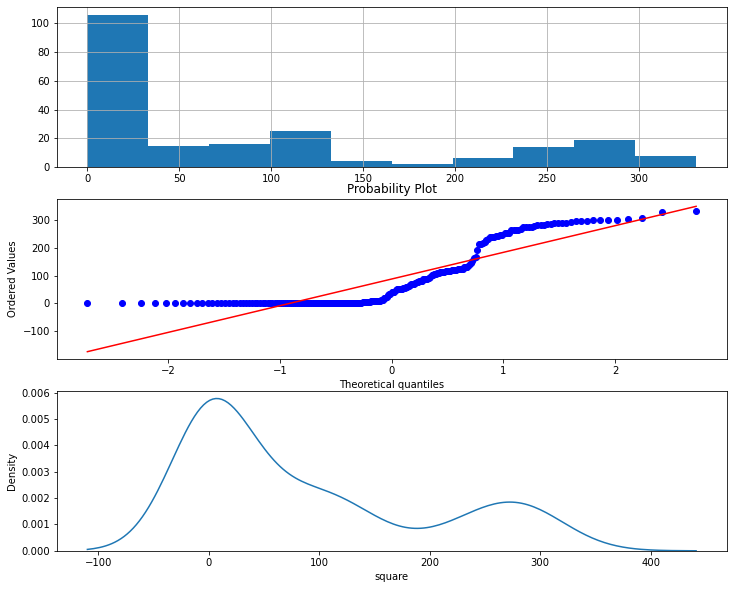

In [61]:
# for square transformation
fig_plot(transformation["square"])

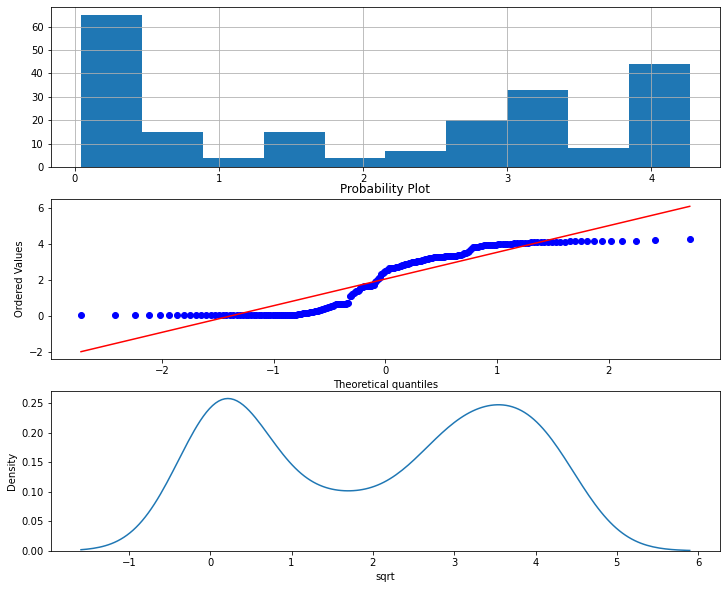

In [62]:
# for square root transformation
fig_plot(transformation["sqrt"])

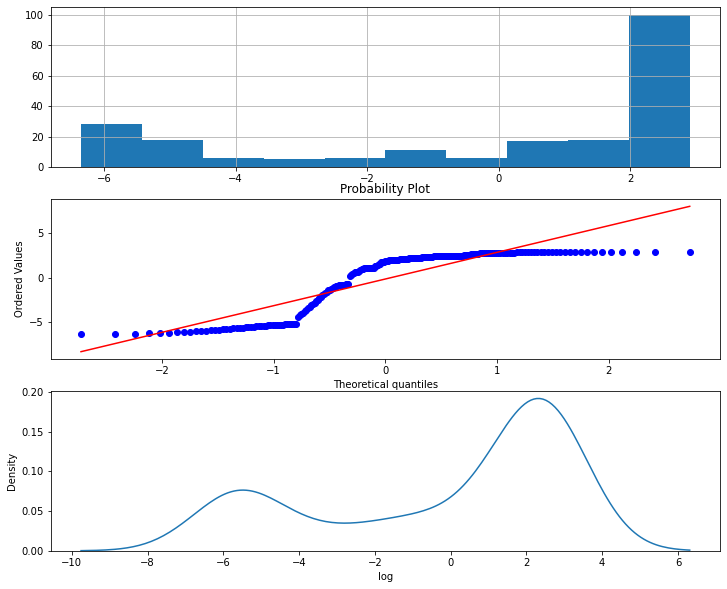

In [63]:
# for log transformation
fig_plot(transformation["log"])

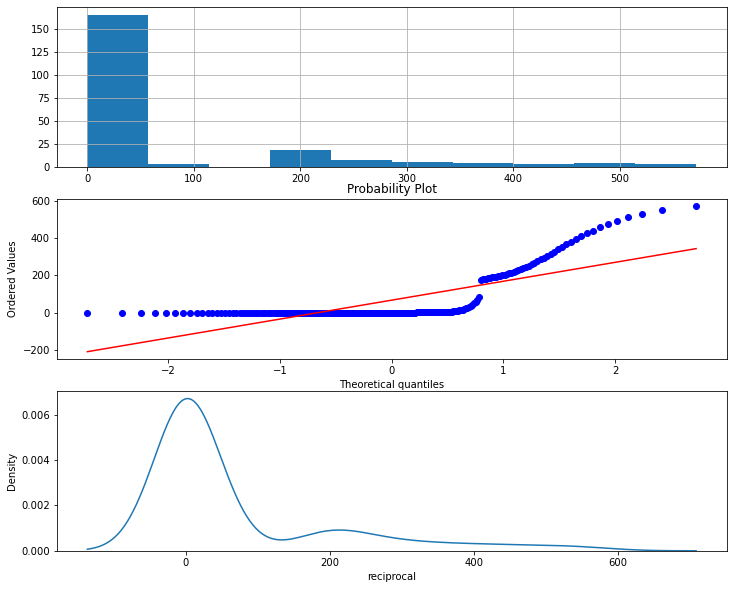

In [64]:
# for reciprocal transformation
fig_plot(transformation["reciprocal"])

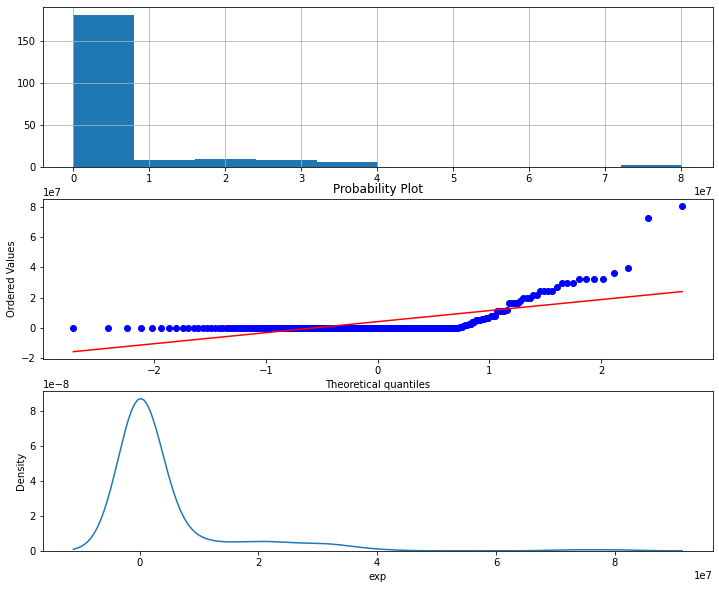

In [65]:
# for exp transformation
fig_plot(transformation["exp"])

In [66]:
# Lets use boxcox transformation
from scipy.stats import boxcox , yeojohnson
bcx_target, lam= boxcox(df1["CO2"])
bcx_target = pd.DataFrame(bcx_target, columns=["trans"])

In [67]:
bcx_target.head()

,trans
0,-3.094412
1,-3.098401
2,-3.101852
3,-3.105915
4,-3.109430


In [68]:
lam

0.21904684941499802

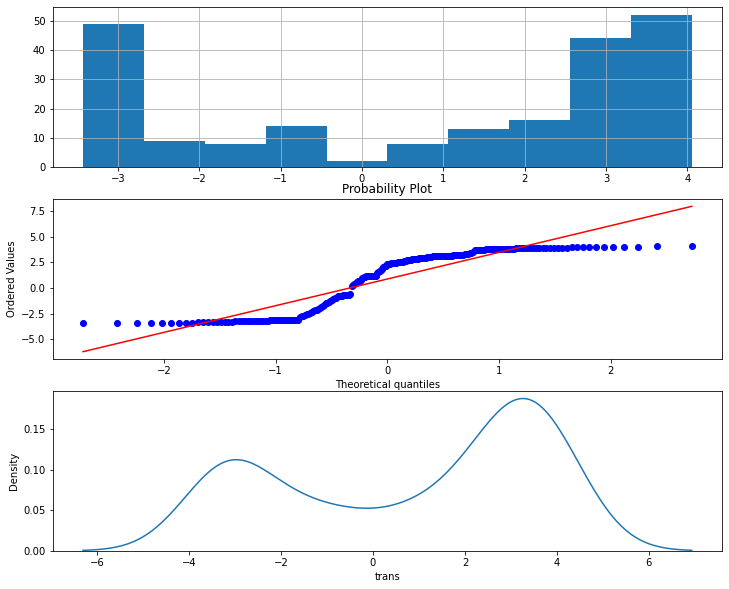

In [69]:
fig_plot(bcx_target["trans"])

In [70]:
yeo_target, lam1 =yeojohnson(df1["CO2"])
yeo_target = pd.DataFrame(yeo_target, columns=["trans"])
yeo_target.head()

,trans
0,0.005667
1,0.005597
2,0.005537
3,0.005467
4,0.005408


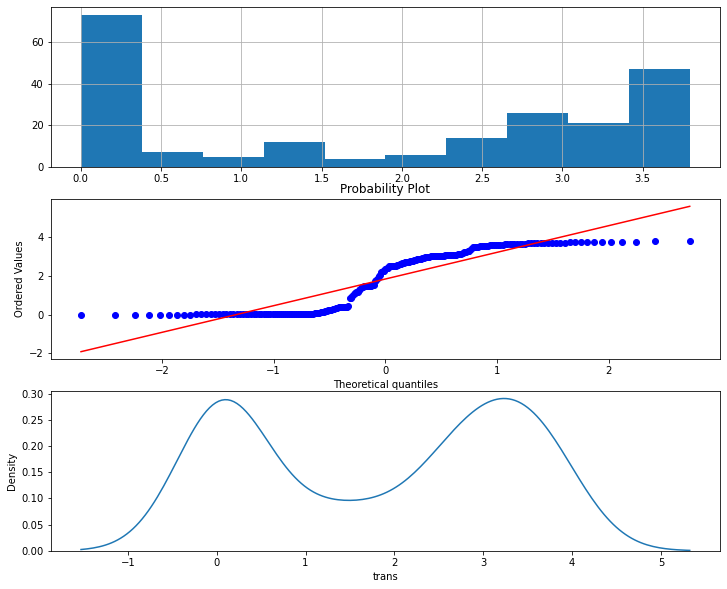

In [71]:
fig_plot(yeo_target["trans"])

## It can be seen that, after making transformations also, the data is not having normal distribution

#  checking the Stationarity of the series

In [72]:
df2 = df.copy()
df2.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [73]:
df2.set_index("Year", inplace= True)
df2.head()

,CO2
Year,
1800,0.00568
1801,0.00561
1802,0.00555
1803,0.00548
1804,0.00542


In [74]:
# lets use the Augments Dickey Fuller test to check the Stationarity by using the function
from statsmodels.tsa.stattools import adfuller
def adfuller_test(data):
    print('Results of Dickey Fuller Test:')
    result = adfuller(data, autolag='AIC')
    label=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value, label in zip(result, label):
        print(f"{label} :- {value}")

In [75]:
adfuller_test(df2) # from p value above we can see that series is not Stationary  

Results of Dickey Fuller Test:
Test Statistic :- -0.3784627751558869
p-value :- 0.9136330950336237
#Lags Used :- 0
Number of Observations Used :- 214


In [76]:
#Test whether Timeseries is Stationary or not
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=2).mean()
    rolstd = timeseries.rolling(window=2).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

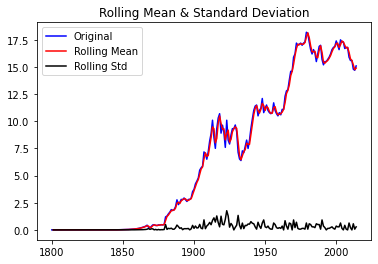

In [77]:
test_stationarity(df2)

In [78]:
# lets take first difference to make the data stationary

In [79]:
df2["first_diff"]= df2 - df2.shift(1)
df2.head()

,CO2,first_diff
Year,,
1800,0.00568,NaN
1801,0.00561,-0.00007
1802,0.00555,-0.00006
1803,0.00548,-0.00007
1804,0.00542,-0.00006


In [80]:
adfuller_test(df2.first_diff.dropna())

Results of Dickey Fuller Test:
Test Statistic :- -3.7800045305842556
p-value :- 0.003118649594241994
#Lags Used :- 15
Number of Observations Used :- 198


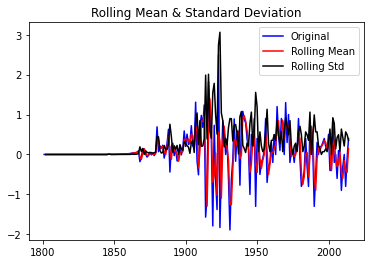

In [81]:
test_stationarity(df2.first_diff.dropna())